In [2]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from numpy import array

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

Using TensorFlow backend.


# Input data:

In [3]:
# Read csv of Education distribution
# Remove all the entries that don't have "County"
df = pd.read_csv('Education_data_compiled.csv')
df = df[df['Area name'].str.contains('County')]
df = df.sort_values(by=['State','Area name'])#,ignore_index=True)

In [4]:
# Add columns of Unemployment and Median HH Income
new_df = pd.read_csv('Unemployed_data_compiled.csv')
new_df = new_df[new_df['Area name'].str.contains('County')]
new_df.sort_values(by=['Area name'])#,ignore_index=True)

# For this file, area name stick with state => split it
def f(x,delm=','):
    return x.split(delm)[0], x.split(delm)[1][1:]

new_df['State'] = new_df['Area name'].map(lambda x: f(x)[1])
new_df['Area name'] = new_df['Area name'].map(lambda x: f(x)[0])
new_df['Median_Household_Income_2018'] = new_df['Median_Household_Income_2018'].map(lambda x: (f(x)[0]+f(x)[1]))

new_df = new_df.sort_values(by=['State','Area name'])#,ignore_index=True)
result = pd.merge(df,new_df,how='inner', on=['Area name','State'])
df = result.rename(columns={"Area name": "County", "Unemployment_rate_2019": "Percent of unemployment 2019", 
                       "Median_Household_Income_2018": "Median Household Income 2018"})
df["Median Household Income 2018"] = df["Median Household Income 2018"].astype(float)

# Normalize stationary data

In [5]:
df_norm = df.copy()
df_norm["Median Household Income 2018"]=df_norm["Median Household Income 2018"]/np.max(df_norm["Median Household Income 2018"])*100

In [6]:
# Add data of covid case
COVID_counties_df=pd.read_csv('us_counties_covid19_daily.csv')
del COVID_counties_df['fips']

# Testing with Baltimore county
COVID_baltimore_df=COVID_counties_df[COVID_counties_df['county']=='Baltimore']
stat_data_baltimore_df=df_norm.loc[df['County'].str.contains('Baltimore')&df['State'].str.contains('MD')]


# Extracting number:
stat_data_baltimore = stat_data_baltimore_df.drop(columns=['County', 'State']).values.tolist()
stat_data_baltimore = np.array(stat_data_baltimore[0])

# Prediction

In [7]:
# Run the prediction

# split a univariate sequence into samples
def split_sequence(sequence, n_steps, features_data): #features = other data of the county 
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        seq_x = np.append(seq_x,features_data)
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

# Perform prediction 
def single_pred(x_input, n_steps, features_length, n_features):
    x_input = x_input.reshape((1, n_steps+features_length, n_features))
    yhat = model.predict(x_input, verbose=0)
    return yhat

def make_prediction(cases_train, n_steps, features_data, num_pred):
    features_length = len(features_data)
    yhat_array = np.zeros(num_pred)
    for i in range(num_pred):
        if i < len(cases_train)-n_steps:
            x_input = cases_train[i:i+n_steps]
            x_input = np.append(x_input,features_data)
            yhat = single_pred(x_input, n_steps, features_length, n_features)
            yhat_array[i] = yhat
        else:
            x_input = np.append(x_input[1:n_steps],yhat) # create feature from previous prediction
            x_input = np.append(x_input,features_data) # insert stationary feature
            yhat = single_pred(x_input, n_steps, features_length, n_features)
            yhat_array[i] = yhat
    return yhat_array


In [8]:
# Data:
cases = np.array(COVID_baltimore_df['cases'])
# Split data to train the model: 70:30
test_train_split = 0.7
cases_train = cases[0:int(len(cases)*test_train_split)]
cases_test = cases[int(len(cases)*test_train_split):]

features_data = stat_data_baltimore
features_length = len(features_data)

In [12]:
# Perform prediction:

# choose a number of time steps (how many days to use for prediction)
n_steps = 3

# split into samples
X, y = split_sequence(cases_train, n_steps,features_data)
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps+features_length, n_features)))  # features_length is length of features_data array 
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# fit model
model.fit(X, y, epochs=200, verbose=0)

yhat_array = make_prediction(cases_train, n_steps, stat_data_baltimore,len(cases)-n_steps)
#print(yhat_array)


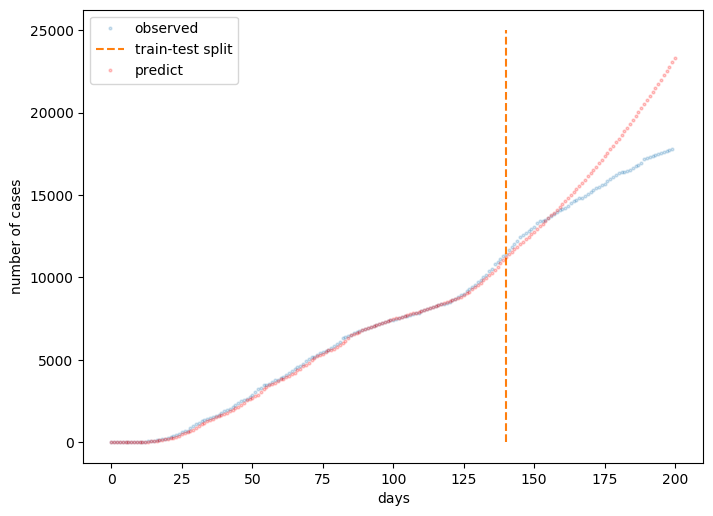

In [13]:
fig,ax = plt.subplots(figsize=(8,6),dpi=100)
ax.plot(cases,'o',markersize=2,alpha=0.2,label='observed')
#ax.plot(np.append(cases_train,yhat_array),'or',markersize=2,alpha=0.2,label='predict')
ax.plot([int(len(cases)*test_train_split),int(len(cases)*test_train_split)],[0,25000],'--',label='train-test split')
ax.plot(np.append(cases[0:n_steps+1],yhat_array),'or',markersize=2,alpha=0.2,label='predict')
ax.set_xlabel('days')
ax.set_ylabel('number of cases')
ax.legend()

# Testing performance with different steps

<bound method Figure.show of <Figure size 864x1080 with 6 Axes>>

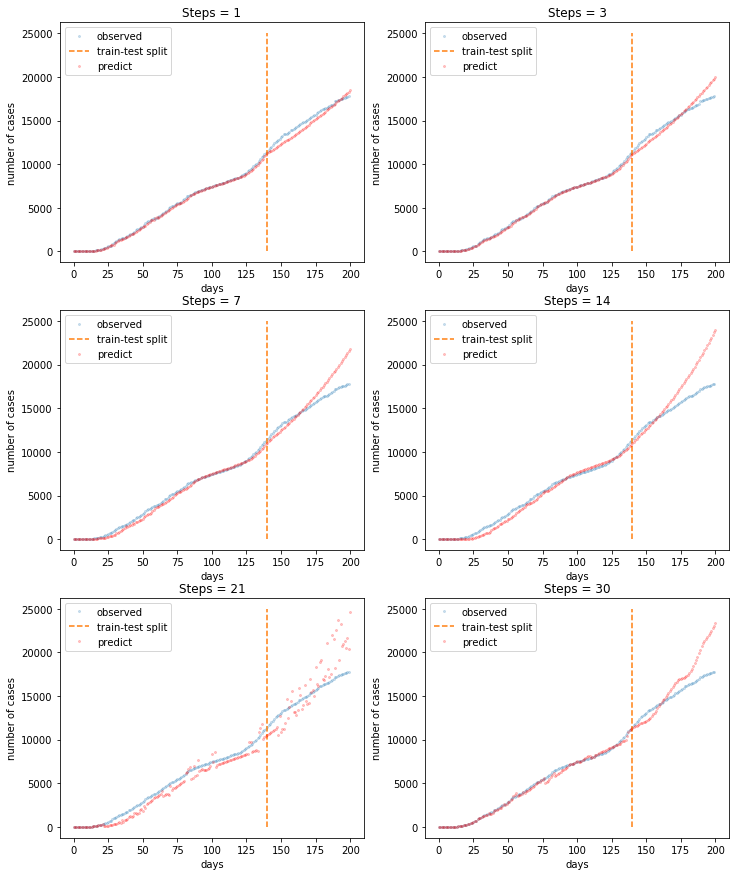

In [14]:
steps_list = [1,3,7,14,21,30]

fig,ax = plt.subplots(3,2,figsize=(12,15))

# By the way, take a look at these numpy commands: reshape and where
rowcollist = np.arange(1,7)

# 4,3 means 4 rows, 3 columns
rowcollist = rowcollist.reshape(3,2)

for i in range(0,len(rowcollist)):
    row,col = np.where(rowcollist == i+1)
    #print(row[0], col[0])

# Perform prediction:
for i in range(len(steps_list)):
    # choose a number of time steps (how many days to use for prediction)
    n_steps = steps_list[i]

    # split into samples
    X, y = split_sequence(cases_train, n_steps,features_data)
    # reshape from [samples, timesteps] into [samples, timesteps, features]
    n_features = 1
    X = X.reshape((X.shape[0], X.shape[1], n_features))

    # define model
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(n_steps+features_length, n_features)))  # features_length is length of features_data array 
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # fit model
    model.fit(X, y, epochs=200, verbose=0)

    yhat_array = make_prediction(cases_train, n_steps, stat_data_baltimore,len(cases)-n_steps)
    #print(yhat_array)

    row, col = np.where(rowcollist == i+1)
    ax[row[0]][col[0]].plot(cases,'o',markersize=2,alpha=0.2,label='observed')
    ax[row[0]][col[0]].plot([int(len(cases)*test_train_split),int(len(cases)*test_train_split)],[0,25000],'--',label='train-test split')
    ax[row[0]][col[0]].plot(np.append(cases[0:n_steps+1],yhat_array),'or',markersize=2,alpha=0.2,label='predict')
    ax[row[0]][col[0]].set_xlabel('days')
    ax[row[0]][col[0]].set_ylabel('number of cases')
    ax[row[0]][col[0]].legend()
    ax[row[0]][col[0]].set_title('Steps = ' + str(steps_list[i]))
fig.show

In [44]:
delta_array

array([ 2.66787529e-01,  6.34606838e-01,  3.44809532e-01,  1.43388271e+00,
       -7.59405136e-01, -3.59074116e+00,  2.69246578e+00,  1.85209846e+00,
       -7.09585190e-01, -2.99202728e+00, -7.43873596e-01,  5.25769424e+00,
       -4.81143188e+00,  9.34692383e-01, -1.70562744e-01, -1.01898193e-01,
       -3.20831299e-01, -1.98241577e+01, -6.66516113e+01, -1.15408066e+02,
       -1.75657043e+02, -2.28052368e+02, -3.16241699e+02, -3.64657867e+02,
       -3.60139069e+02, -5.66311462e+02, -6.72233032e+02, -7.58783325e+02,
       -8.53846161e+02, -9.32404938e+02, -1.03139514e+03, -1.04276770e+03,
       -1.15149658e+03, -1.17954526e+03, -1.22988562e+03, -1.32149542e+03,
       -1.38635153e+03, -1.52543460e+03, -1.57372748e+03, -1.66021387e+03,
       -1.77787943e+03, -1.87771088e+03, -2.02969611e+03, -2.14982394e+03,
       -2.18808417e+03, -2.27146725e+03, -2.37996454e+03, -2.46856781e+03,
       -2.64926968e+03, -2.81906317e+03, -2.93594177e+03, -3.08289960e+03,
       -3.06393097e+03, -

# Find Delta with Varying Steps

<bound method Figure.show of <Figure size 864x1080 with 6 Axes>>

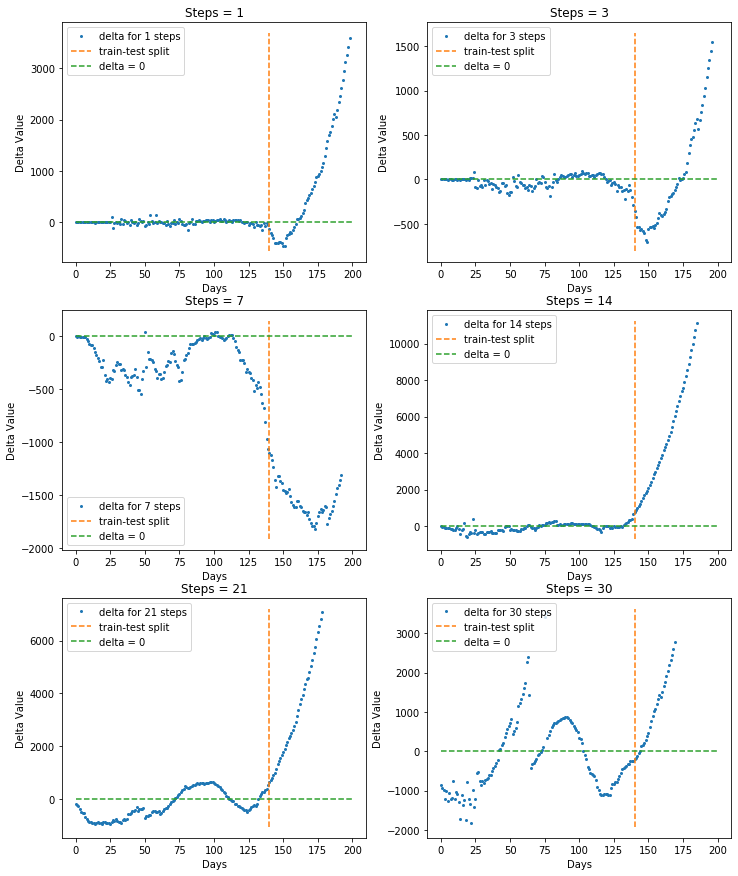

In [47]:
steps_list = [1,3,7,14,21,30]
# Data:
cases = np.array(COVID_baltimore_df['cases'])
# Split data to train the model: 70:30
test_train_split = 0.7
cases_train = cases[0:int(len(cases)*test_train_split)]
cases_test = cases[int(len(cases)*test_train_split):]

features_data = stat_data_baltimore
features_length = len(features_data)

fig,ax = plt.subplots(3,2,figsize=(12,15))

# By the way, take a look at these numpy commands: reshape and where
rowcollist = np.arange(1,7)

# 4,3 means 4 rows, 3 columns
rowcollist = rowcollist.reshape(3,2)

for i in range(0,len(rowcollist)):
    row,col = np.where(rowcollist == i+1)
    #print(row[0], col[0])

# Perform prediction:
for i in range(len(steps_list)):
    # choose a number of time steps (how many days to use for prediction)
    n_steps = steps_list[i]

    # split into samples
    X, y = split_sequence(cases_train, n_steps,features_data)
    # reshape from [samples, timesteps] into [samples, timesteps, features]
    n_features = 1
    X = X.reshape((X.shape[0], X.shape[1], n_features))

    # define model
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(n_steps+features_length, n_features)))  # features_length is length of features_data array 
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # fit model
    model.fit(X, y, epochs=200, verbose=0)

    yhat_array = make_prediction(cases_train, n_steps, stat_data_baltimore,len(cases)-n_steps)
    #print(yhat_array)
    
    delta_array = yhat_array - cases[(len(cases)-len(yhat_array)):]
    
    row, col = np.where(rowcollist == i+1)
    ax[row[0]][col[0]].plot(delta_array,'o',markersize=2,label='delta for '+str(steps_list[i])+ ' steps')
    ax[row[0]][col[0]].plot([int(len(cases)*test_train_split),int(len(cases)*test_train_split)],[min(delta_array)-100,max(delta_array)+100],'--',label='train-test split')
    ax[row[0]][col[0]].plot([0,200],[0,0],'--',label='delta = 0')
    ax[row[0]][col[0]].set_xlabel('Days')
    ax[row[0]][col[0]].set_ylabel('Delta Value')
    ax[row[0]][col[0]].legend()
    ax[row[0]][col[0]].set_title('Steps = ' + str(steps_list[i]))
fig.show

# Find Delta with Different Test Set Sizes

<bound method Figure.show of <Figure size 864x1080 with 6 Axes>>

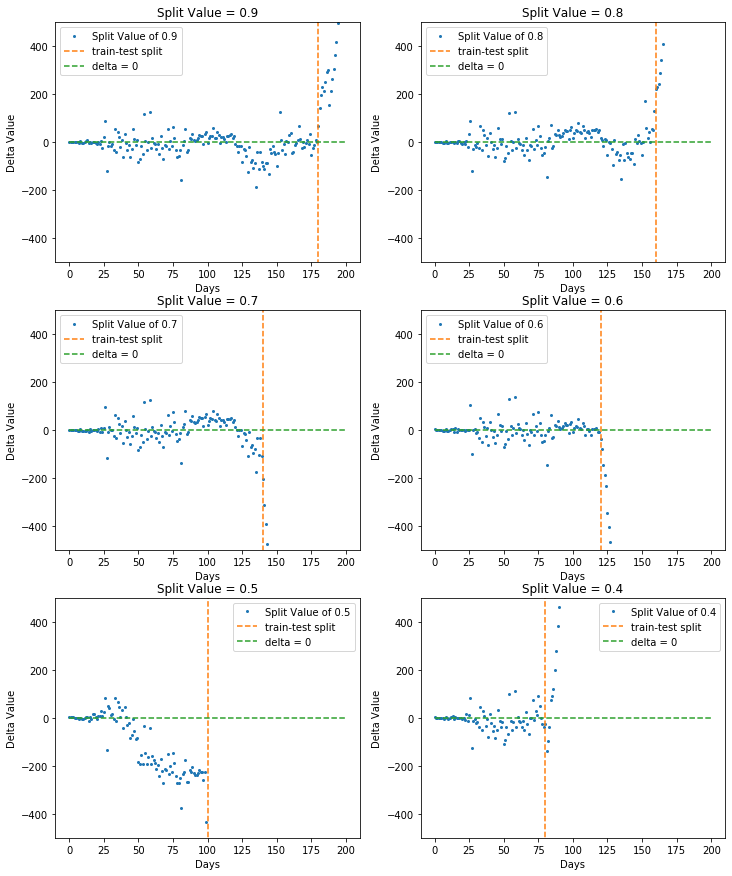

In [30]:
# Data:
cases = np.array(COVID_baltimore_df['cases'])
# Split data to train the model: 70:30
split_value = [0.9, 0.8, 0.7, 0.6, 0.5, 0.4]

fig,ax = plt.subplots(3,2,figsize=(12,15))

# By the way, take a look at these numpy commands: reshape and where
rowcollist = np.arange(1,7)

# 4,3 means 4 rows, 3 columns
rowcollist = rowcollist.reshape(3,2)

for i in range(0,len(rowcollist)):
    row,col = np.where(rowcollist == i+1)
    #print(row[0], col[0])

for i in range(0,len(split_value)):
    cases_train = cases[0:int(len(cases)*split_value[i])]
    cases_test = cases[int(len(cases)*split_value[i]):]

    features_data = stat_data_baltimore
    features_length = len(features_data)

    # Perform prediction:
    # choose a number of time steps (how many days to use for prediction)
    n_steps = 1

    # split into samples
    X, y = split_sequence(cases_train, n_steps,features_data)
    # reshape from [samples, timesteps] into [samples, timesteps, features]
    n_features = 1
    X = X.reshape((X.shape[0], X.shape[1], n_features))

    # define model
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(n_steps+features_length, n_features)))  # features_length is length of features_data array 
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # fit model
    model.fit(X, y, epochs=200, verbose=0)

    yhat_array = make_prediction(cases_train, n_steps, stat_data_baltimore,len(cases)-n_steps)
    #print(yhat_array)

    delta_array = yhat_array - cases[(len(cases)-len(yhat_array)):]
    
    row, col = np.where(rowcollist == i+1)
    ax[row[0]][col[0]].plot(delta_array,'o',markersize=2,label='Split Value of '+str(split_value[i]))
    ax[row[0]][col[0]].plot([int(len(cases)*split_value[i]),int(len(cases)*split_value[i])],[-20000,50000],'--',label='train-test split')
    ax[row[0]][col[0]].plot([0,200],[0,0],'--',label='delta = 0')
    ax[row[0]][col[0]].set_ylim(bottom = -500, top = 500)
    ax[row[0]][col[0]].set_xlabel('Days')
    ax[row[0]][col[0]].set_ylabel('Delta Value')
    ax[row[0]][col[0]].legend()
    ax[row[0]][col[0]].set_title('Split Value = ' + str(split_value[i]))
fig.show

# Plot actual value with error on bar graph

<bound method Figure.show of <Figure size 864x1080 with 1 Axes>>

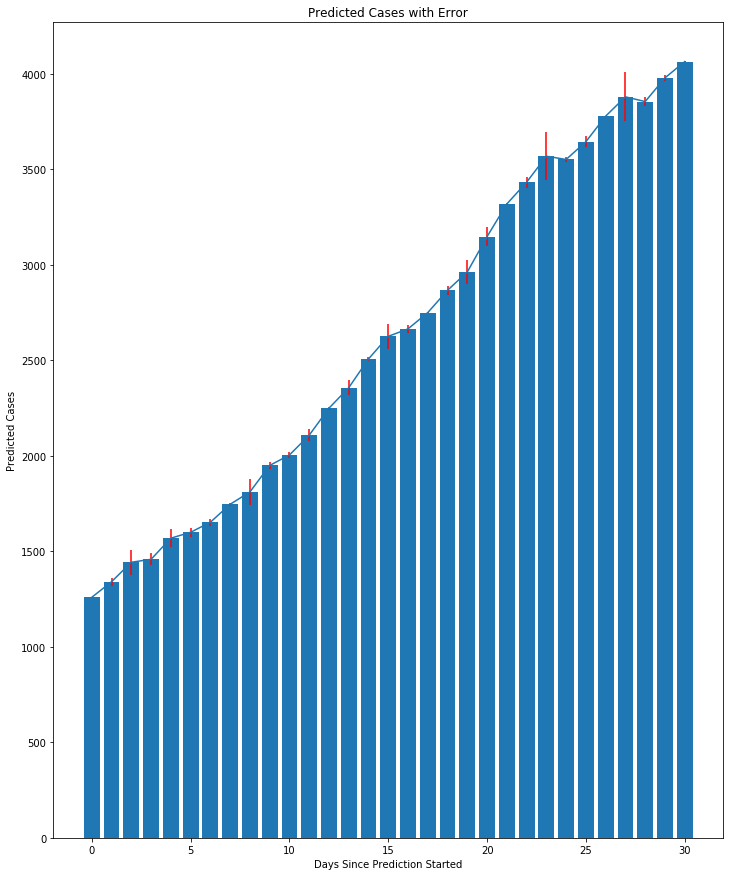

In [31]:
# Data:
cases = np.array(COVID_baltimore_df['cases'])
# Split data to train the model: 70:30
split_value = 0.9

fig,ax = plt.subplots(1,1,figsize=(12,15))

cases_train = cases[0:int(len(cases)*split_value)]
cases_test = cases[int(len(cases)*split_value):]

features_data = stat_data_baltimore
features_length = len(features_data)

# Perform prediction:
# choose a number of time steps (how many days to use for prediction)
n_steps = 1
    
# split into samples
X, y = split_sequence(cases_train, n_steps,features_data)
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps+features_length, n_features)))  # features_length is length of features_data array 
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# fit model
model.fit(X, y, epochs=200, verbose=0)

yhat_array = make_prediction(cases_train, n_steps, stat_data_baltimore,len(cases)-n_steps)
#print(yhat_array)

delta_array = yhat_array - cases[(len(cases)-len(yhat_array)):]

ax.bar(x = range(0,31),height = yhat_array[31:62])
ax.set_xlabel('Days Since Prediction Started')
ax.set_ylabel('Predicted Cases')
ax.errorbar(x = range(0,31),y = yhat_array[31:62],yerr = delta_array[31:62],ecolor='red')
ax.set_title('Predicted Cases with Error')
fig.show

<bound method Figure.show of <Figure size 864x1080 with 1 Axes>>

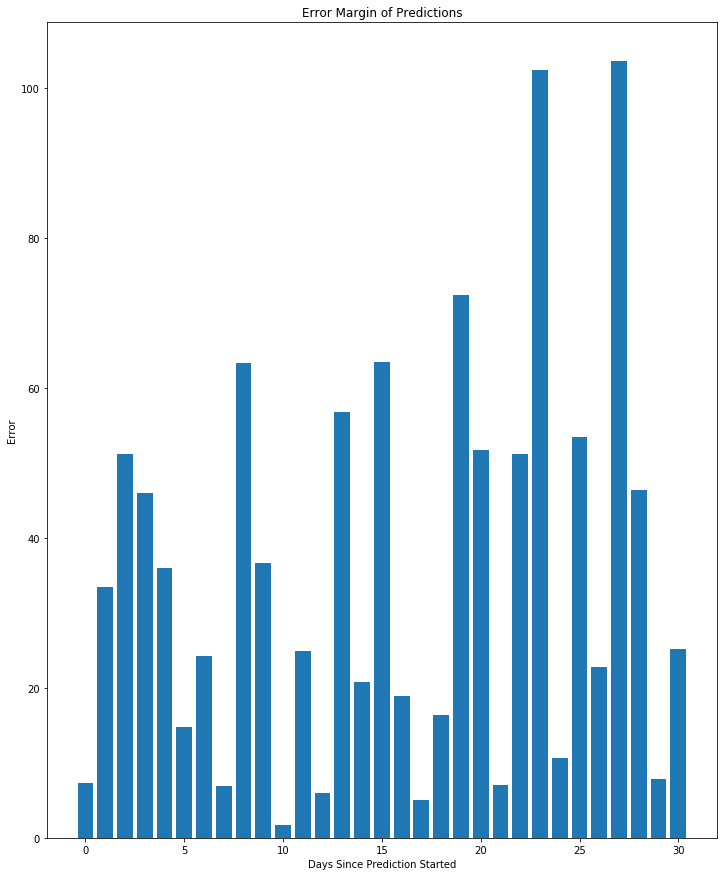

In [33]:
# Data:
cases = np.array(COVID_baltimore_df['cases'])
# Split data to train the model: 70:30
split_value = 0.9

fig,ax = plt.subplots(1,1,figsize=(12,15))

cases_train = cases[0:int(len(cases)*split_value)]
cases_test = cases[int(len(cases)*split_value):]

features_data = stat_data_baltimore
features_length = len(features_data)

# Perform prediction:
# choose a number of time steps (how many days to use for prediction)
n_steps = 1
    
# split into samples
X, y = split_sequence(cases_train, n_steps,features_data)
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps+features_length, n_features)))  # features_length is length of features_data array 
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# fit model
model.fit(X, y, epochs=200, verbose=0)

yhat_array = make_prediction(cases_train, n_steps, stat_data_baltimore,len(cases)-n_steps)
#print(yhat_array)

delta_array = yhat_array - cases[(len(cases)-len(yhat_array)):]

ax.bar(x = range(0,31),height = abs(delta_array[31:62]))
ax.set_xlabel('Days Since Prediction Started')
ax.set_ylabel('Error')
ax.set_title('Error Margin of Predictions')
fig.show

In [29]:
delta_array

array([ 2.86889291e+00,  1.86889291e+00,  1.36658621e+00,  2.06149149e+00,
        1.06149149e+00,  1.90943384e+00, -1.09056616e+00, -3.67495632e+00,
        4.42253494e+00, -1.57746506e+00, -3.32700729e+00, -7.48897552e-01,
        6.61289215e-01,  4.00747299e+00, -2.16594696e+00,  3.14675903e+00,
       -7.21282959e+00,  6.56503296e+00,  9.63302612e+00,  8.39599609e-01,
       -7.77282715e+00, -1.43334961e+00, -5.82800293e+00,  1.36755981e+01,
       -1.59165039e+01,  2.99450073e+01,  8.73499756e+01, -1.22414490e+02,
       -1.54469604e+01,  3.66552734e+00, -5.17065430e+00,  9.13415527e+00,
       -1.45173340e+01,  7.12988281e+01, -2.57513428e+01,  5.60125732e+01,
        3.44473877e+01, -5.65209961e+00,  2.34937744e+01, -4.84991455e+01,
        4.74818115e+01,  1.12462158e+01, -1.70834961e+01,  3.40454102e+00,
       -4.74365234e+01, -1.49125977e+01,  6.68134766e+01,  2.16386719e+01,
       -3.82104492e+00,  1.54731445e+01, -7.71459961e+01, -6.73994141e+01,
       -1.54882812e+01, -

(array([2.180e+02, 1.071e+03, 1.065e+03, 4.050e+02, 1.290e+02, 6.600e+01,
        2.800e+01, 8.000e+00, 8.000e+00, 1.000e+00]),
 array([ 2573. ,  3723.9,  4874.8,  6025.7,  7176.6,  8327.5,  9478.4,
        10629.3, 11780.2, 12931.1, 14082. ]),
 <BarContainer object of 10 artists>)

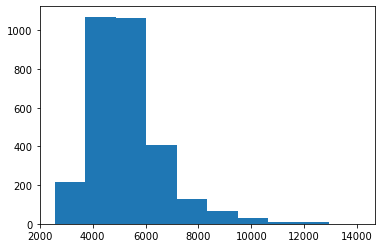

In [7]:
df
plt.hist(df['Median Household Income 2018'])